In [1]:
library(tidyverse)
library(ape)
library(TreeSim)
library(phytools)
library(mvtnorm)
library(phylolm)
library(broom)
library(scales)
library(VGAM)
library(sn)
library(moments)
library(vroom)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘ape’


The following object is masked from ‘package:dplyr’:

    where


Loading required package: geiger

Loading required package: phytools

Loading required package: maps


Attaching package: ‘maps’


The following object is masked from ‘packag

In [2]:
fungi_tree = read.tree("data/gene_expression/fungi_tree.tre")

In [3]:
fungi_data = read_table("data/gene_expression/gene_expression_tpm_matrix_updated_Standard.LogNorm.tsv")


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  Protein = col_character()
)
ℹ Use `spec()` for the full column specifications.



In [4]:
interactions = read_table("data/gene_expression/interactions.txt")


── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  Protein_1 = col_character(),
  Protein_2 = col_character(),
  Type = col_character(),
  Score = col_double()
)



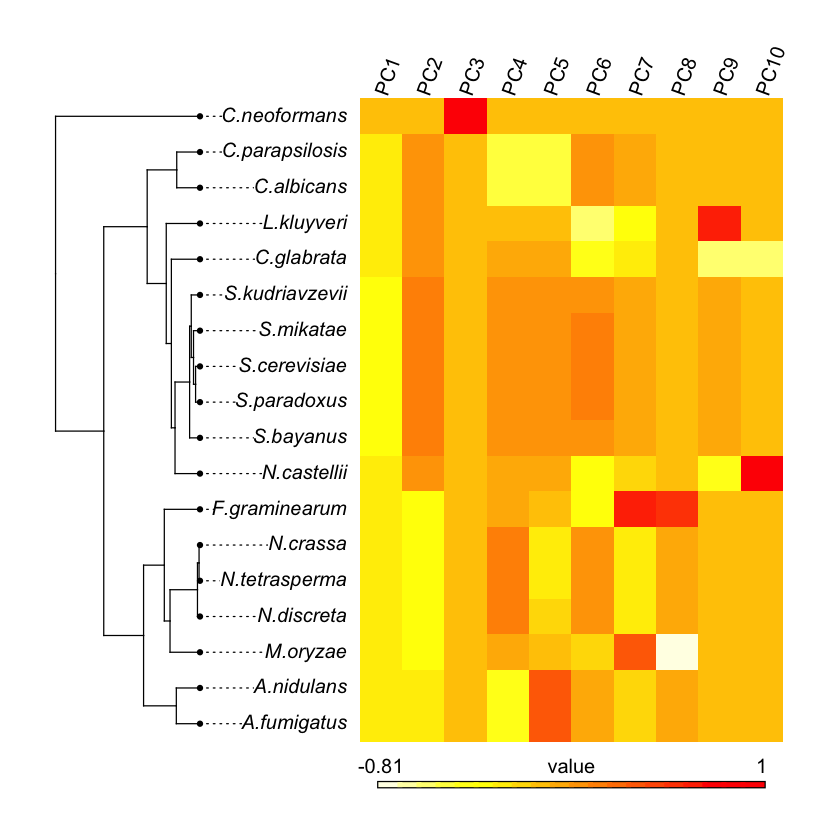

In [5]:
#Make PC heatmap
fungi_PC = eigen(vcv(fungi_tree))$vectors
rownames(fungi_PC) = rownames(vcv(fungi_tree))
colnames(fungi_PC) = paste0("PC",1:ncol(fungi_PC))

phylo.heatmap(fungi_tree,fungi_PC[,1:10])

In [6]:
res_PC = vroom(Sys.glob("data/gene_expression/res_PC*.tsv"))

Rows: 8108750 Columns: 7
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Variable, comparison
dbl (5): Estimate, StdErr, t.value, p.value, PC

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
res_no_PC = vroom(Sys.glob("data/gene_expression/res_no_PC*.tsv"))

Rows: 2495000 Columns: 7
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Variable, comparison
dbl (5): Estimate, StdErr, t.value, p.value, PC

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
res_both = res_no_PC %>% 
    filter(Variable=="X") %>% 
    inner_join(
        res_PC %>% 
            filter(Variable=="X"),
        by=c("comparison","PC"),
        suffix=c("_no_PC","_PC")
    ) %>%
    group_by(PC) %>% 
    mutate(p.adj_no_PC = p.adjust(p.value_no_PC,method="BH"),p.adj_PC = p.adjust(p.value_PC,method="BH")) %>%
    separate(comparison,into=c("Protein_1","Protein_2"),sep="_vs_") 

In [10]:
summary_no_PC = res_both %>% 
    left_join(interactions) %>%
    left_join(interactions,by=c("Protein_1"="Protein_2","Protein_2"="Protein_1")) %>%
    mutate(Type = ifelse(is.na(Type.x)&is.na(Type.y),"nonbinding","binding")) %>%
    select(-Type.x,-Type.y,-Score.x,-Score.y) %>%
    filter(p.adj_no_PC < 0.05) %>%
    group_by(PC) %>%
    summarise(n = n(), frac_binding_no_PC = mean(Type=="binding"))

Joining with `by = join_by(Protein_1, Protein_2)`
Warning message in left_join(., interactions):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 16597 of `x` matches multiple rows in `y`.
ℹ Row 7310 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”
Warning message in left_join(., interactions, by = c(Protein_1 = "Protein_2", Protein_2 = "Protein_1")):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 16772 of `x` matches multiple rows in `y`.
ℹ Row 8810 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”


In [11]:
summary_PC = res_both %>% 
    left_join(interactions) %>%
    left_join(interactions,by=c("Protein_1"="Protein_2","Protein_2"="Protein_1")) %>%
    mutate(Type = ifelse(is.na(Type.x)&is.na(Type.y),"nonbinding","binding")) %>%
    select(-Type.x,-Type.y,-Score.x,-Score.y) %>%
    filter(p.adj_PC < 0.05) %>%
    group_by(PC) %>%
    summarise(n = n(), frac_binding_PC = mean(Type=="binding"))

Joining with `by = join_by(Protein_1, Protein_2)`
Warning message in left_join(., interactions):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 16597 of `x` matches multiple rows in `y`.
ℹ Row 7310 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”
Warning message in left_join(., interactions, by = c(Protein_1 = "Protein_2", Protein_2 = "Protein_1")):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 16772 of `x` matches multiple rows in `y`.
ℹ Row 8810 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


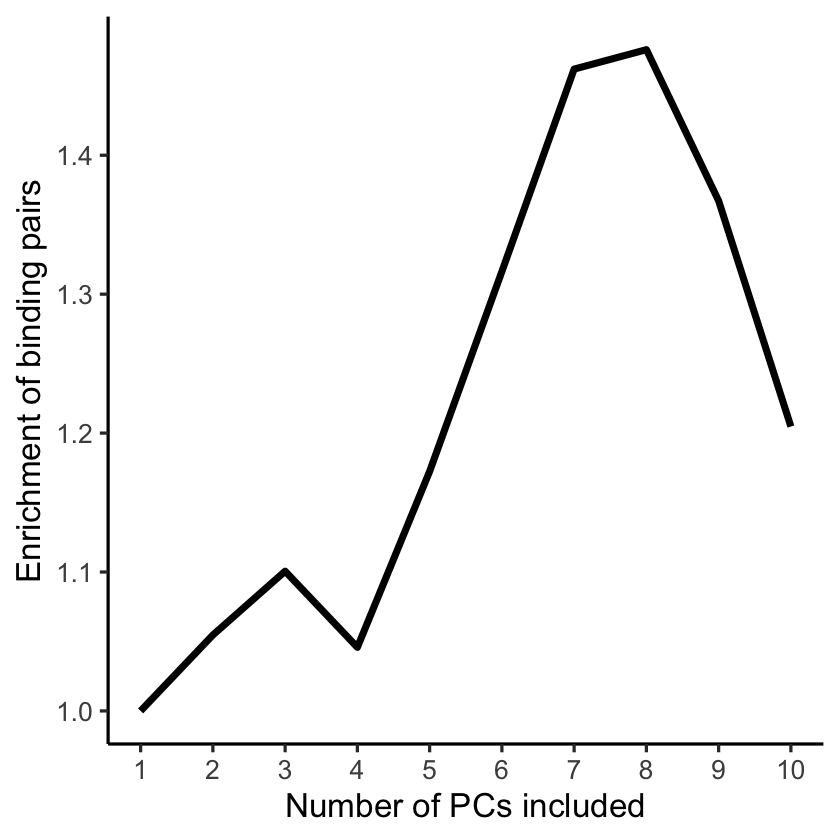

In [12]:
inner_join(summary_no_PC,summary_PC,by=c("PC"),suffix=c("_no_PC","_PC")) %>%
    ggplot(aes(PC,frac_binding_PC/frac_binding_no_PC)) +
    geom_line(size=2) + 
    xlab("Number of PCs included") +
    ylab("Enrichment of binding pairs") +
    theme_classic() +
    scale_x_continuous(breaks=1:10) +
    theme_classic(base_size = 20)

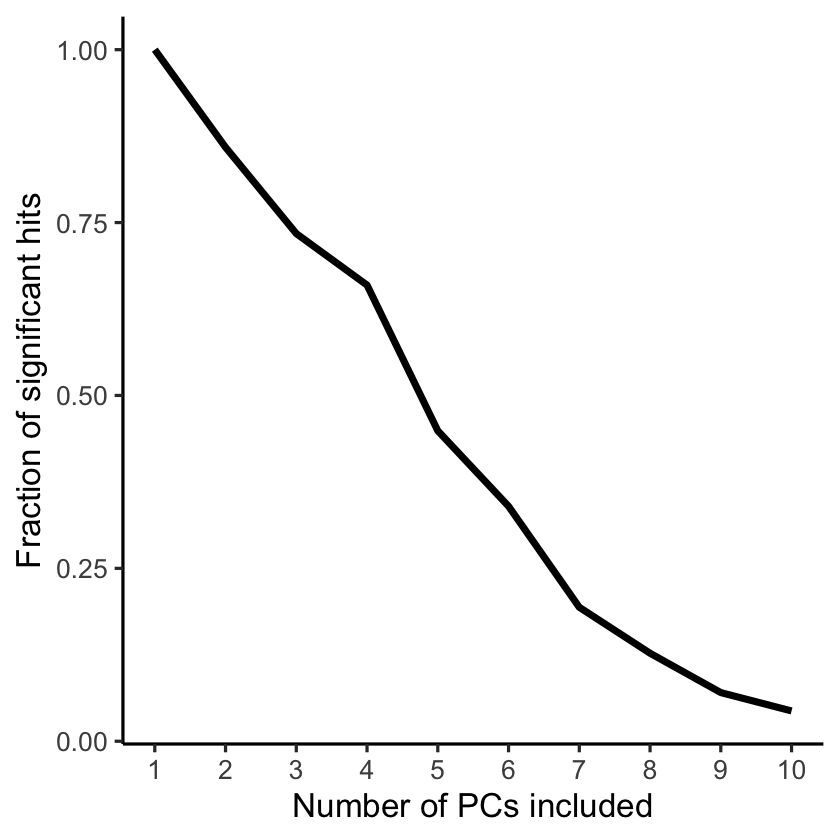

In [13]:
inner_join(summary_no_PC,summary_PC,by=c("PC"),suffix=c("_no_PC","_PC")) %>%
    ggplot(aes(PC,n_PC/n_no_PC)) +
    geom_line(size=2) + 
    xlab("Number of PCs included") +
    ylab("Fraction of significant hits") +
    theme_classic() +
    scale_x_continuous(breaks=1:10) +
    theme_classic(base_size = 20)